## STAT 301 Final Group Report

In [1]:
library(tidyverse)
library(glmnet)
library(tidymodels)
library(mltools)
library(leaps)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1

In [2]:
tips <- read.csv("tips.csv",stringsAsFactors=TRUE)
#tips$size <- as.factor(tips$size)
head(tips)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


In [3]:
tips |>
group_by(size) |>
summarise(numsize = n())

tips |>
group_by(day) |>
summarise(numsize = n())

size,numsize
<int>,<int>
1,4
2,156
3,38
4,37
5,5
6,4


day,numsize
<fct>,<int>
Fri,19
Sat,87
Sun,76
Thur,62


In [12]:
set.seed(1234)

tips_split <- tips |>
initial_split(prop = 0.7, strata = tip)

tips_train <- training(tips_split)
tips_test <- testing(tips_split)

In [13]:
#tips_step <- stepAIC(lm(tip ~ .,tips))

ERROR: Error in stepAIC(lm(tip ~ ., tips)): could not find function "stepAIC"


In [14]:
tips_forward_selection <- regsubsets(x = tip ~ total_bill + sex + smoker + day + size, nvmax = 8,
                                  data = tips_train,
                                  method = "forward")

tips_forward_summary <- summary(tips_forward_selection)
tips_forward_summary

Subset selection object
Call: regsubsets.formula(x = tip ~ total_bill + sex + smoker + day + 
    size, nvmax = 8, data = tips_train, method = "forward")
7 Variables  (and intercept)
           Forced in Forced out
total_bill     FALSE      FALSE
sexMale        FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
size           FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         total_bill sexMale smokerYes daySat daySun dayThur size
1  ( 1 ) "*"        " "     " "       " "    " "    " "     " " 
2  ( 1 ) "*"        " "     " "       " "    " "    " "     "*" 
3  ( 1 ) "*"        " "     "*"       " "    " "    " "     "*" 
4  ( 1 ) "*"        "*"     "*"       " "    " "    " "     "*" 
5  ( 1 ) "*"        "*"     "*"       " "    "*"    " "     "*" 
6  ( 1 ) "*"        "*"     "*"       "*"    "*"    " "     "*" 
7  ( 1 ) "*"        "*"     "*"       "*"    "

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.5088118,170.3694,0.5058528
2,0.5164914,167.7057,0.5106307
3,0.5186569,166.9547,0.5098518
4,0.5196344,166.6156,0.5078463
5,0.5196752,166.6014,0.5048504
6,0.5197377,166.5798,0.5018397
7,0.5197693,166.5688,0.4987592


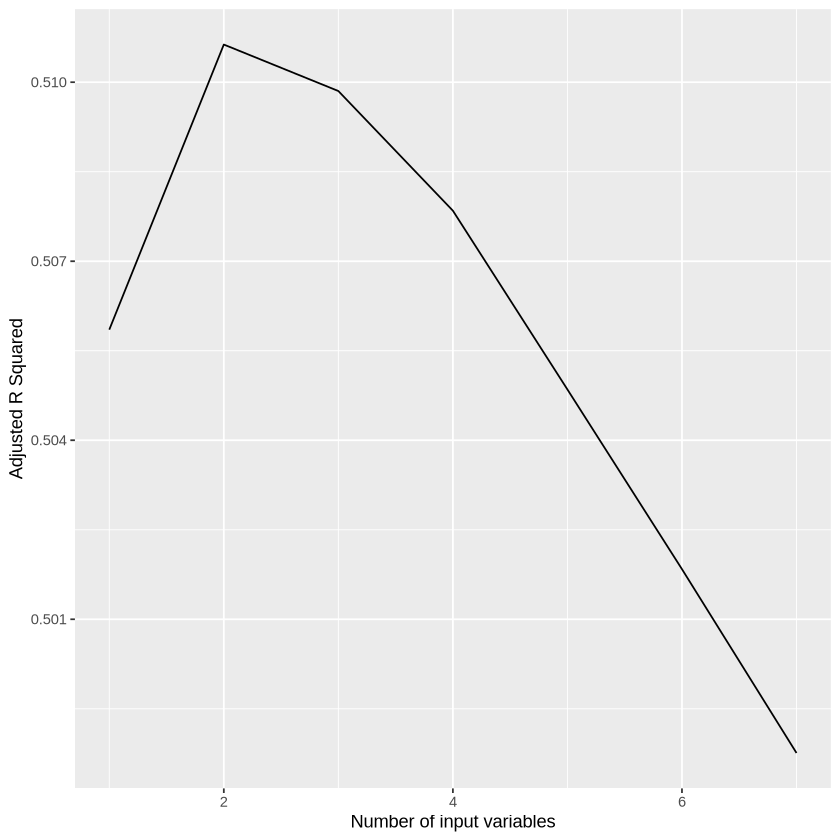

In [15]:
tips_fwd_summary_df <- 
    tibble(
        n_input_variables = 1:7,
        RSQ = tips_forward_summary$rsq,
        RSS = tips_forward_summary$rss,
        ADJ.R2 = tips_forward_summary$adjr2
    )
tips_fwd_summary_df
ggplot(tips_fwd_summary_df,aes(x =  n_input_variables,y = ADJ.R2)) +
geom_line() + 
labs(x = "Number of input variables",
     y = "Adjusted R Squared",)

In [16]:
vif(lm(tip ~ ., tips_train))

,GVIF,Df,GVIF^(1/(2*Df))
total_bill,1.698853,1,1.303400
sex,1.127794,1,1.061977
smoker,1.172588,1,1.082861
day,11.956322,3,1.512166
time,10.747515,1,3.278340
size,1.656404,1,1.287014


In [21]:
tips_linear_model <- lm(tip ~ total_bill + size, tips_test)

In [22]:
anova(lm(tip ~ 1, tips_test),tips_linear_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,75,117.67307,NA,NA,NA,NA
2,73,76.67159,2,41.00148,19.51902,1.619737e-07


In [23]:
anova(tips_linear_model, lm(tip ~ ., tips_test))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,73,76.67159,NA,NA,NA,NA
2,67,72.02565,6,4.645938,0.7202939,0.6346344


In [24]:
tidy(tips_linear_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.92514056,0.3498233,2.644594,0.0100074031
total_bill,0.06557151,0.0186871,3.508918,0.0007745505
size,0.28154416,0.1502867,1.873381,0.0650189193
